In [ ]:
Notes on getting data:
    -https://www.premierleague.com/match/59065 gives all information (goals, yellow/red cards, fouls)
    -https://www.football-data.org/ is good API, but need to pay for yellow cards (have emailed asking for access)
    -https://github.com/openfootball/england/tree/master/2020-21 is good, but just has goals  
    -https://elenasport.io/ Looks promising, need to sign up. Have signed up, contains yellow cards. Think shall go with this.   

In [150]:
import requests
import http.client 
import json
import pprint
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import t
from datetime import datetime
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f#Reading in API key
file = open("rapid_api_key.txt")
rapid_api_key = file.read().strip("\n")
#Now saved as global variable, so can be used inside functions

In [3]:
#Start of making functions

#Function to retrieve json object from API endpoint
def makeRequest(url, querystring = {}):
    
    headers = {
    'x-rapidapi-key': rapid_api_key,
    'x-rapidapi-host': "elenasport-io1.p.rapidapi.com"
    }
    
    response = requests.request("GET", url, headers=headers, params = querystring)
    if(response.status_code == 404):
        print("Connection not made, returning nothing")
        return 0
    if(response.status_code == 200):      
        print(f"Response code is {response.status_code}, all is well")
    response_data_json = response.json()
    return response_data_json

In [4]:
#Order of getting infomration from ElenaSport.io

# Country ID
# League ID
# Seasons by League ID
# Fixtures by Season ID
# stats by Fixture ID

In [5]:
def getCountryIDfromCountryName(country_name):
    url = "https://elenasport-io1.p.rapidapi.com/v2/countries"
    query_string = {"name":"Eng","page":"1"}
    response_data_json = makeRequest(url, query_string)
    
    for keys in response_data_json['data']:
        print(keys['name'])
        if(keys['name'] == country_name):
            country_id = keys['id']
            print(f"Country id for {country_name} is {country_id}")
            return country_id

In [6]:
country_id = getCountryIDfromCountryName('England')

Response code is 200, all is well
England
Country id for England is 27


In [20]:
def getLeagueIDfromCountryID(league_name, country_id):
    url =  f"https://elenasport-io1.p.rapidapi.com/v2/countries/{country_id}/leagues"
    print(f"League url is {url}")
    league_data_json = makeRequest(url)
    
    for key in league_data_json['data']:
        print(key['name'])
        print(league_name)
        if(str(key['name']) == str(league_name)):
            print(f"{league_name} id is {key['id']}")
            return key['id']
        

In [21]:
league_id = getLeagueIDfromCountryID('Premier League', 27)

League url is https://elenasport-io1.p.rapidapi.com/v2/countries/27/leagues
Response code is 200, all is well
FA Cup
Premier League
Premier League
Premier League
Premier League id is 234


In [9]:
def getLeagueIDfromLeagues(leagueName, leagues_id):
    #Takes in JSON file
    
    url =  f"https://elenasport-io1.p.rapidapi.com/v2/countries/{country_id}/leagues"
    print(f"Leagues url is {url}")
    leagues_data_json = makeRequest(url)
    
    for key in leagues_json['data']:
        print(key['name'])
        print(leagueName)
        if(str(key['name']) == str(leagueName)):
            
#         if(leagueName in key):
            print(f"{leagueName} id is {key['id']}")
            return key['id']    

In [10]:
league_id = getLeagueIDfromLeagues('Premier League', leagues_data_json)

NameError: name 'leagues_data_json' is not defined

In [18]:
def getSeasonIDfromLeagueID(season_name, league_id):
    url = f"https://elenasport-io1.p.rapidapi.com/v2/leagues/{league_id}/seasons"
    print(f"Season url is {url}")
    league_json = makeRequest(url)
    for key in league_json['data']:
        print(key['leagueName'])
        print(season_name)
        if(str(key['leagueName']) == str(season_name)):
            print(f"{season_name} id is {key['id']}")
            return key['id']
    

In [22]:
season_id = getSeasonIDfromLeagueID("Premier League - 2019/2020", league_id)

Season url is https://elenasport-io1.p.rapidapi.com/v2/leagues/234/seasons
Response code is 200, all is well
Premier League - 2020/2021
Premier League - 2019/2020
Premier League - 2019/2020
Premier League - 2019/2020
Premier League - 2019/2020 id is 96


In [106]:
def getFixturesfromSeasonID(season_id):
    print(f"Getting fixtures from season ID {season_id}")
    url = f"https://elenasport-io1.p.rapidapi.com/v2/seasons/{season_id}/fixtures"
    print(f"Url is {url}")
    fixtureData = []
    
    for page_no in range(1, 25): 
        print(f"\nGetting data from page {page_no}\n")
        querystring = {"page":str(page_no),"expand":"stats,events"}
        season_json = makeRequest(url, querystring)

        for fixture_counter, fixture in enumerate(season_json['data']):
#             print(f"Date: {fixture['date']}")
            print(fixture_counter)
            fixtureData.append(getFixtureStats(fixture))

    return fixtureData

In [97]:
def getFixtureStats(fixture):
    print(f"Date: {fixture['date']}")
    print(f"Score: {fixture['homeName']} {fixture['team_home_90min_goals']} - {fixture['team_away_90min_goals']} {fixture['awayName']}")

    #Getting number of y_cards
    y_card_sum = 0
    try:
        for event in fixture['expand']['events']:
            if (event['type'] == 'y_card'):
#                 print(f"{event['type']} at {event['elapsed']} minutes")
                y_card_sum = y_card_sum + 1 
    except:
        print("No events found")
        
    #Getting number of r_cards
    r_card_sum = 0
    try:
        for event in fixture['expand']['events']:
            if (event['type'] == 'r_card'):
#                 print(f"{event['type']} at {event['elapsed']} minutes")
                r_card_sum = r_card_sum + 1 
    except:
        print("No events found")
        
        
#     if((fixture['homeName'] == 'Newcastle United') and (fixture['awayName'] == 'Sheffield United')):    
    if((fixture['homeName'] == 'Watford') and (fixture['awayName'] == 'Liverpool')):    
        print(f"\n\n\nFOUND THE FIXTURE\n\n\n")
        print(fixture['homeName'], fixture['awayName'], fixture['date'], y_card_sum, r_card_sum)
    
#     print(f"y card sum = {y_card_sum}")
#     print(f"r card sum = {r_card_sum}")
    
    return [datetime.strptime(fixture['date'], '%Y-%m-%d %H:%M:%S'), fixture['homeName'], fixture['awayName'], fixture['team_home_90min_goals'], fixture['team_away_90min_goals'], r_card_sum, y_card_sum]

In [107]:
fixtureData = getFixturesfromSeasonID(season_id)

Getting fixtures from season ID 96
Url is https://elenasport-io1.p.rapidapi.com/v2/seasons/96/fixtures

Getting data from page 1

Response code is 200, all is well
0
Date: 2020-06-21 13:00:00
Score: Newcastle United 3 - 0 Sheffield United
1
Date: 2020-06-27 11:30:00
Score: Aston Villa 0 - 1 Wolverhampton Wanderers
2
Date: 2020-07-01 19:15:00
Score: West Ham United 3 - 2 Chelsea
3
Date: 2020-07-11 11:30:00
Score: Watford 2 - 1 Newcastle United
4
Date: 2020-07-11 14:00:00
Score: Liverpool 1 - 1 Burnley
5
Date: 2020-07-11 16:30:00
Score: Sheffield United 3 - 0 Chelsea
6
Date: 2020-07-11 19:00:00
Score: Brighton & Hove Albion 0 - 5 Manchester City
7
Date: 2020-07-12 11:00:00
Score: Wolverhampton Wanderers 3 - 0 Everton
8
Date: 2020-07-12 13:15:00
Score: Aston Villa 2 - 0 Crystal Palace
9
Date: 2020-07-12 15:30:00
Score: Tottenham Hotspur 2 - 1 Arsenal
10
Date: 2020-07-12 18:00:00
Score: AFC Bournemouth 4 - 1 Leicester City
11
Date: 2020-07-13 19:00:00
Score: Manchester United 2 - 2 Southam

Response code is 200, all is well
0
Date: 2019-12-29 16:30:00
Score: Liverpool 1 - 0 Wolverhampton Wanderers
1
Date: 2019-12-29 18:00:00
Score: Manchester City 2 - 0 Sheffield United
2
Date: 2020-01-01 12:30:00
Score: Brighton & Hove Albion 1 - 1 Chelsea
3
Date: 2020-01-01 12:30:00
Score: Burnley 1 - 2 Aston Villa
4
Date: 2020-01-01 15:00:00
Score: Newcastle United 0 - 3 Leicester City
5
Date: 2020-01-01 15:00:00
Score: Southampton 1 - 0 Tottenham Hotspur
6
Date: 2020-01-01 15:00:00
Score: Watford 2 - 1 Wolverhampton Wanderers
7
Date: 2020-01-01 17:30:00
Score: Manchester City 2 - 1 Everton
8
Date: 2020-01-01 17:30:00
Score: Norwich City 1 - 1 Crystal Palace
9
Date: 2020-01-01 17:30:00
Score: West Ham United 4 - 0 AFC Bournemouth
10
Date: 2020-01-01 20:00:00
Score: Arsenal 2 - 0 Manchester United
11
Date: 2020-01-02 20:00:00
Score: Liverpool 2 - 0 Sheffield United
12
Date: 2020-01-10 20:00:00
Score: Sheffield United 1 - 0 West Ham United
13
Date: 2020-01-11 12:30:00
Score: Crystal Pala

Response code is 200, all is well
0
Date: 2019-08-09 19:00:00
Score: Liverpool 4 - 1 Norwich City
1
Date: 2019-08-10 14:00:00
Score: Burnley 3 - 0 Southampton
2
Date: 2019-08-10 16:30:00
Score: Tottenham Hotspur 3 - 1 Aston Villa
3
Date: 2019-08-11 13:00:00
Score: Newcastle United 0 - 1 Arsenal
4
Date: 2019-08-17 14:00:00
Score: Brighton & Hove Albion 1 - 1 West Ham United
5
Date: 2020-07-04 14:00:00
Score: Leicester City 3 - 0 Crystal Palace
6
Date: 2020-07-04 14:00:00
Score: Manchester United 5 - 2 AFC Bournemouth
7
Date: 2020-07-04 16:30:00
Score: Wolverhampton Wanderers 0 - 2 Arsenal
8
Date: 2020-07-04 19:00:00
Score: Chelsea 3 - 0 Watford
9
Date: 2020-07-05 11:00:00
Score: Burnley 1 - 1 Sheffield United
10
Date: 2020-07-16 17:00:00
Score: Everton 1 - 1 Aston Villa
11
Date: 2020-07-16 19:15:00
Score: Crystal Palace 0 - 2 Manchester United
12
Date: 2020-07-16 19:15:00
Score: Southampton 1 - 1 Brighton & Hove Albion
13
Date: 2020-07-17 19:00:00
Score: West Ham United 3 - 1 Watford
14

Response code is 200, all is well

Getting data from page 17

Response code is 200, all is well

Getting data from page 18

Response code is 200, all is well

Getting data from page 19

Response code is 200, all is well

Getting data from page 20

Response code is 200, all is well

Getting data from page 21

Response code is 200, all is well

Getting data from page 22

Response code is 200, all is well

Getting data from page 23

Response code is 200, all is well

Getting data from page 24

Response code is 200, all is well


In [101]:
#Reading in fixture data to dataframe
columns = ['Date', 'Home Team', 'Away Team', 'Away Goals', 'Home Goals', 'Red Cards', 'Yellow cards']
fixture_df = pd.DataFrame(data=fixtureData, columns = columns)
fixture_df.tail()

,Date,Home Team,Away Team,Away Goals,Home Goals,Red Cards,Yellow cards
361,2019-12-07 15:00:00,AFC Bournemouth,Liverpool,0,3,0,1
362,2019-12-07 15:00:00,Tottenham Hotspur,Burnley,5,0,0,2
363,2019-12-07 15:00:00,Watford,Crystal Palace,0,0,0,5
364,2019-12-07 17:30:00,Manchester City,Manchester United,1,2,0,5
365,2019-12-08 14:00:00,Aston Villa,Leicester City,1,4,0,8


In [102]:
fixture_df.sort_values(by='Date', inplace = True, ignore_index=True)
fixture_df

,Date,Home Team,Away Team,Away Goals,Home Goals,Red Cards,Yellow cards
0,2019-08-09 19:00:00,Liverpool,Norwich City,4,1,0,2
1,2019-08-10 11:30:00,West Ham United,Manchester City,0,5,0,4
2,2019-08-10 14:00:00,Watford,Brighton & Hove Albion,0,3,0,1
3,2019-08-10 14:00:00,Crystal Palace,Everton,0,0,0,4
4,2019-08-10 14:00:00,AFC Bournemouth,Sheffield United,1,1,0,3
...,...,...,...,...,...,...,...
361,2020-07-26 15:00:00,Chelsea,Wolverhampton Wanderers,2,0,0,5
362,2020-07-26 15:00:00,Everton,AFC Bournemouth,1,3,0,1
363,2020-07-26 15:00:00,Leicester City,Manchester United,0,2,1,6
364,2020-07-26 15:00:00,Newcastle United,Liverpool,1,3,0,1


In [103]:
fixture_df[(fixture_df['Away Team'] == 'Liverpool') | (fixture_df['Home Team'] == 'Liverpool')]

,Date,Home Team,Away Team,Away Goals,Home Goals,Red Cards,Yellow cards
0,2019-08-09 19:00:00,Liverpool,Norwich City,4,1,0,2
14,2019-08-17 14:00:00,Southampton,Liverpool,1,2,0,3
26,2019-08-24 16:30:00,Liverpool,Arsenal,3,1,0,2
37,2019-08-31 16:30:00,Burnley,Liverpool,0,3,0,0
40,2019-09-14 11:30:00,Liverpool,Newcastle United,3,1,0,0
59,2019-09-22 15:30:00,Chelsea,Liverpool,1,2,0,6
60,2019-09-28 11:30:00,Sheffield United,Liverpool,0,1,0,2
73,2019-10-05 14:00:00,Liverpool,Leicester City,2,1,0,5
87,2019-10-20 15:30:00,Manchester United,Liverpool,1,1,0,1
97,2019-10-27 16:30:00,Liverpool,Tottenham Hotspur,2,1,0,6


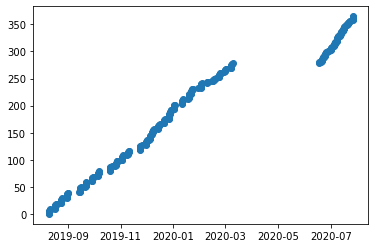

In [104]:
# fixture_df.Date.plot(kind='kde')
plt.scatter(fixture_df.Date, np.arange(0, len(fixture_df)))

In [105]:
print(len(fixture_df))
print(fixture_df['Date'][0])
print(fixture_df['Date'][len(fixture_df)-1])


366
2019-08-09 19:00:00
2020-07-26 15:00:00


In [108]:
type(fixture_df.Date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [109]:
def split_data_by_date(df, date):
    date = datetime.strptime(date, '%Y-%m-%d')
    df1 = df[(df['Date'] > date) & (df['Yellow cards'] < 7)]
    df2 = df[(df['Date'] < date) & (df['Yellow cards'] < 7)]
    
#     df1 = df.sample(int(1 * len(df)), replace = False)
#     df2 = df.sample(int(1 * len(df)), replace = False)
    
    print(f"Fixtures after {date} =  {len(df1)}")
    print(f"Fixtures before {date} =  {len(df2)}")
    
    return df1, df2
    

In [110]:
fixture_df_AC, fixture_df_BC = split_data_by_date(fixture_df, '2020-05-01')

Fixtures after 2020-05-01 00:00:00 =  86
Fixtures before 2020-05-01 00:00:00 =  254


Text(0.5, 0, 'Yellow Cards per game')

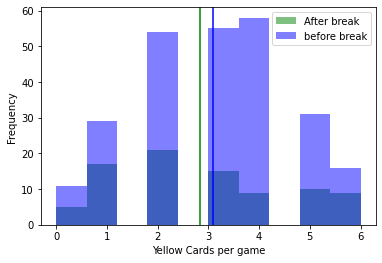

In [137]:
fixture_df_AC['Yellow cards'].plot.hist(alpha=0.5, color='green', label='After break')
fixture_df_BC['Yellow cards'].plot.hist(alpha=0.5, color='blue', label='before break')
plt.axvline(fixture_df_AC['Yellow cards'].mean(), color='green')
plt.axvline(fixture_df_BC['Yellow cards'].mean(), color='blue')
plt.legend()
plt.xlabel("Yellow Cards per game")

In [124]:
def calculate_t_statistic(data1, data2, alpha = 0.05):
    #Calculate t-test
    mean1, mean2 = data1.mean(), data2.mean()
    print(f"Means: {mean1}, {mean2}")
    std1, std2 = data1.std(), data2.std()
    print(f"Stds: {std1}, {std2}")
    N1, N2 = len(data1), len(data2)
    print(f"Counts: {N1}, {N2}")
    std_err_1, std_err_2 = std1/np.sqrt(N1), std2/np.sqrt(N2)
    print(f"Std errors: {std_err_1}, {std_err_2}")
    t_stat = (mean1 - mean2)/np.sqrt(std_err_1 * std_err_1 + std_err_2 * std_err_2)
    print(f"t_stat is {t_stat}")
    
    #degrees of freedom
    deg_f = N1 + N2 - 2
    print(f"Number of deg_f are {deg_f}")
    
    #Calculating the critical value
    crit_val = t.ppf(1.0 - alpha, deg_f)
    print(f"Critical value is {crit_val}")
    
    p_val = (1.0 - t.cdf(abs(t_stat), df = deg_f)) * 2.0
    print(f"p value is {p_val:.5f}")
    
    if(p_val < alpha):
        print("Statistically significant difference, can reject null hypothesis")
    else:
        print("No statistically significant difference, cannot reject null hypothesis")
        
    if(crit_val < abs(t_stat)):
        print("Statistically significant difference, can reject null hypothesis")
    else:
        print("No statistically significant difference, cannot reject null hypothesis")
        

Text(0.5, 0, 'Yellow Cards per game')

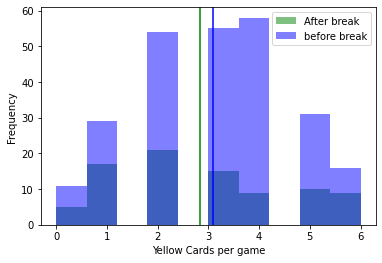

In [146]:
fixture_df_AC['Yellow cards'].plot.hist(alpha=0.5, color='green', label='After break')
fixture_df_BC['Yellow cards'].plot.hist(alpha=0.5, color='blue', label='before break')
plt.axvline(fixture_df_AC['Yellow cards'].mean(), color='green')
plt.axvline(fixture_df_BC['Yellow cards'].mean(), color='blue')
plt.legend()
plt.xlabel("Yellow Cards per game")

Average yellow cards per game has changed by -0.253


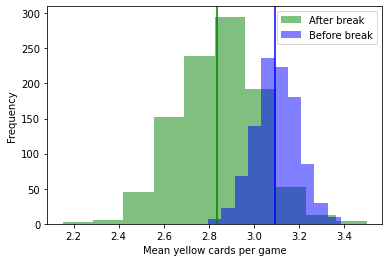

In [141]:
bootstrapped_fixtures_fixture_df_AC_yellow_cards = pd.DataFrame({'Mean Yellow cards' : [fixture_df_AC['Yellow cards'].sample(len(fixture_df_AC), replace=True).mean() for i in range(1000)]})
bootstrapped_fixtures_fixture_df_BC_yellow_cards = pd.DataFrame({'Mean Yellow cards' : [fixture_df_BC['Yellow cards'].sample(len(fixture_df_BC), replace=True).mean() for i in range(1000)]})
bootstrapped_fixtures_fixture_df_AC_yellow_cards['Mean Yellow cards'].plot.hist(alpha=0.5, color='green', label= "After break")
bootstrapped_fixtures_fixture_df_BC_yellow_cards['Mean Yellow cards'].plot.hist(alpha=0.5, color='blue', label= "Before break")
plt.axvline(fixture_df_AC['Yellow cards'].mean(), color='green')
plt.axvline(fixture_df_BC['Yellow cards'].mean(), color='blue')
plt.legend()
plt.xlabel("Mean yellow cards per game")
print("Average yellow cards per game has changed by {:.3f}".format(fixture_df_AC['Yellow cards'].mean() - fixture_df_BC['Yellow cards'].mean()))

In [151]:
calculate_t_statistic(bootstrapped_fixtures_fixture_df_AC_yellow_cards['Mean Yellow cards'], bootstrapped_fixtures_fixture_df_BC_yellow_cards['Mean Yellow cards'])
stats.ttest_ind(bootstrapped_fixtures_fixture_df_AC_yellow_cards['Mean Yellow cards'], bootstrapped_fixtures_fixture_df_BC_yellow_cards['Mean Yellow cards'])

Means: 2.8412790697674346, 3.09593307086615
Stds: 0.18081275678183906, 0.0954841309116864
Counts: 1000, 1000
Std errors: 0.0057178014144466825, 0.003019473340826189
t_stat is -39.38292492694989
Number of deg_f are 1998
Critical value is 1.6456166300576656
p value is 0.00000
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis


Ttest_indResult(statistic=-39.38292492694752, pvalue=1.4731378130005617e-251)

In [153]:
#Adding in sum of goals column
fixture_df['Sum Goals'] = fixture_df['Away Goals'] + fixture_df['Home Goals']
fixture_df.head(20)

,Date,Home Team,Away Team,Away Goals,Home Goals,Red Cards,Yellow cards,Sum Goals
0,2019-08-09 19:00:00,Liverpool,Norwich City,4,1,0,2,5
1,2019-08-10 11:30:00,West Ham United,Manchester City,0,5,0,4,5
2,2019-08-10 14:00:00,Watford,Brighton & Hove Albion,0,3,0,1,3
3,2019-08-10 14:00:00,Crystal Palace,Everton,0,0,0,4,0
4,2019-08-10 14:00:00,AFC Bournemouth,Sheffield United,1,1,0,3,2
5,2019-08-10 14:00:00,Burnley,Southampton,3,0,0,0,3
6,2019-08-10 16:30:00,Tottenham Hotspur,Aston Villa,3,1,0,1,4
7,2019-08-11 13:00:00,Leicester City,Wolverhampton Wanderers,0,0,0,2,0
8,2019-08-11 13:00:00,Newcastle United,Arsenal,0,1,0,4,1
9,2019-08-11 15:30:00,Manchester United,Chelsea,4,0,0,7,4


In [154]:
fixture_df_AC, fixture_df_BC = split_data_by_date(fixture_df, '2020-05-01')
bootstrapped_fixtures_fixture_df_AC_goals = pd.DataFrame({'Mean Goals' : [fixture_df_AC['Sum Goals'].sample(len(fixture_df_AC['Sum Goals']), replace=True).mean() for i in range(1000)]})
bootstrapped_fixtures_fixture_df_BC_goals = pd.DataFrame({'Mean Goals' : [fixture_df_BC['Sum Goals'].sample(len(fixture_df_BC['Sum Goals']), replace=True).mean() for i in range(1000)]})

Fixtures after 2020-05-01 00:00:00 =  86
Fixtures before 2020-05-01 00:00:00 =  254


Text(0.5, 0, 'Goals per game')

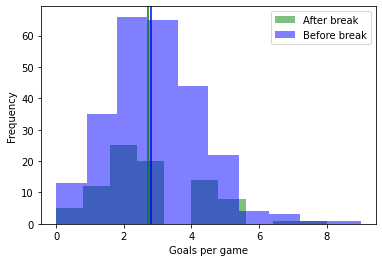

In [181]:
fixture_df_AC['Sum Goals'].plot.hist(alpha=0.5, color='green', label='After break', bins=10)
fixture_df_BC['Sum Goals'].plot.hist(alpha=0.5, color='blue', label='Before break', bins=10)
plt.axvline(fixture_df_AC['Sum Goals'].mean(), color='green')
plt.axvline(fixture_df_BC['Sum Goals'].mean(), color='blue')
plt.legend()
plt.xlabel("Goals per game")

Average goals per game has changed by -0.086


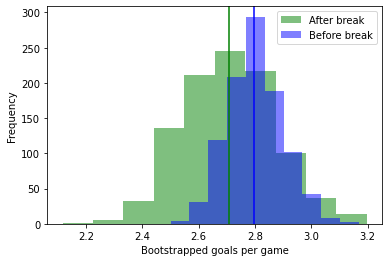

In [182]:
bootstrapped_fixtures_fixture_df_AC_goals['Mean Goals'].plot.hist(alpha=0.5, color='green', label= "After break")
bootstrapped_fixtures_fixture_df_BC_goals['Mean Goals'].plot.hist(alpha=0.5, color='blue', label= "Before break")
plt.axvline(fixture_df_AC['Sum Goals'].mean(), color='green')
plt.axvline(fixture_df_BC['Sum Goals'].mean(), color='blue')
plt.legend()
plt.xlabel("Bootstrapped goals per game")
print("Average goals per game has changed by {:.3f}".format(fixture_df_AC['Sum Goals'].mean() - fixture_df_BC['Sum Goals'].mean()))

In [158]:
calculate_t_statistic(bootstrapped_fixtures_fixture_df_AC_goals['Mean Goals'], bootstrapped_fixtures_fixture_df_BC_goals['Mean Goals'])
stats.ttest_ind(bootstrapped_fixtures_fixture_df_AC_goals['Mean Goals'], bootstrapped_fixtures_fixture_df_BC_goals['Mean Goals'])

Means: 2.70872093023256, 2.8008858267716477
Stds: 0.16343603691803849, 0.09798577553874807
Counts: 1000, 1000
Std errors: 0.005168301284123676, 0.003098582290004563
t_stat is -15.294566207756503
Number of deg_f are 1998
Critical value is 1.6456166300576656
p value is 0.00000
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis


Ttest_indResult(statistic=-15.294566207757756, pvalue=5.055548596461171e-50)

In [ ]:
#Testing for home and away goals

In [159]:
bootstrapped_fixtures_fixture_df_AC_home_goals = pd.DataFrame({'Mean Home Goals' : [fixture_df_AC['Home Goals'].sample(len(fixture_df_AC), replace=True).mean() for i in range(1000)]})
bootstrapped_fixtures_fixture_df_BC_home_goals = pd.DataFrame({'Mean Home Goals' : [fixture_df_BC['Home Goals'].sample(len(fixture_df_AC), replace=True).mean() for i in range(1000)]})

Average home goals per game has changed by -0.078


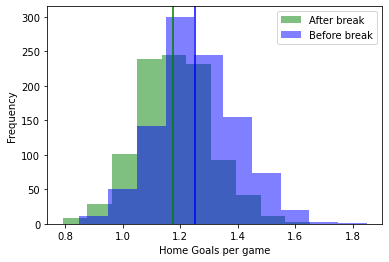

In [170]:
bootstrapped_fixtures_fixture_df_AC_home_goals['Mean Home Goals'].plot.hist(alpha=0.5, color='green', label= "After break")
bootstrapped_fixtures_fixture_df_BC_home_goals['Mean Home Goals'].plot.hist(alpha=0.5, color='blue', label= "Before break")
plt.axvline(fixture_df_AC['Home Goals'].mean(), color='green')
plt.axvline(fixture_df_BC['Home Goals'].mean(), color='blue')
plt.legend()
plt.xlabel("Home Goals per game")
print("Average home goals per game has changed by {:.3f}".format(fixture_df_AC['Home Goals'].mean() - fixture_df_BC['Home Goals'].mean()))

In [171]:
calculate_t_statistic(bootstrapped_fixtures_fixture_df_AC_home_goals['Mean Home Goals'], bootstrapped_fixtures_fixture_df_BC_home_goals['Mean Home Goals'])
stats.ttest_ind(bootstrapped_fixtures_fixture_df_AC_home_goals['Mean Home Goals'], bootstrapped_fixtures_fixture_df_BC_home_goals['Mean Home Goals'])

Means: 1.1786627906976703, 1.2581860465116275
Stds: 0.12632949484083253, 0.13911638866280662
Counts: 1000, 1000
Std errors: 0.0039948893935552125, 0.00439924648031695
t_stat is -13.382272008536052
Number of deg_f are 1998
Critical value is 1.6456166300576656
p value is 0.00000
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis


Ttest_indResult(statistic=-13.38227200853545, pvalue=3.5395138449906787e-39)

In [166]:
bootstrapped_fixtures_fixture_df_AC_away_goals = pd.DataFrame({'Mean Away Goals' : [fixture_df_AC['Away Goals'].sample(len(fixture_df_AC), replace=True).mean() for i in range(1000)]})
bootstrapped_fixtures_fixture_df_BC_away_goals = pd.DataFrame({'Mean Away Goals' : [fixture_df_BC['Away Goals'].sample(len(fixture_df_BC), replace=True).mean() for i in range(1000)]})

Average away goals per game has changed by -0.008


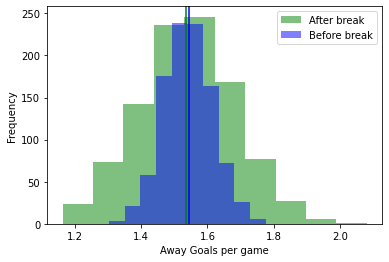

In [173]:
bootstrapped_fixtures_fixture_df_AC_away_goals['Mean Away Goals'].plot.hist(alpha=0.5, color='green', label= "After break")
bootstrapped_fixtures_fixture_df_BC_away_goals['Mean Away Goals'].plot.hist(alpha=0.5, color='blue', label= "Before break")
plt.axvline(fixture_df_AC['Away Goals'].mean(), color='green')
plt.axvline(fixture_df_BC['Away Goals'].mean(), color='blue')
plt.legend()
plt.xlabel("Away Goals per game")
print("Average away goals per game has changed by {:.3f}".format(fixture_df_AC['Away Goals'].mean() - fixture_df_BC['Away Goals'].mean()))

In [174]:
calculate_t_statistic(bootstrapped_fixtures_fixture_df_AC_away_goals['Mean Away Goals'], bootstrapped_fixtures_fixture_df_BC_away_goals['Mean Away Goals'])
stats.ttest_ind(bootstrapped_fixtures_fixture_df_AC_away_goals['Mean Away Goals'], bootstrapped_fixtures_fixture_df_BC_away_goals['Mean Away Goals'])

Means: 1.5379418604651145, 1.53902755905512
Stds: 0.14582021058498076, 0.07272076771184474
Counts: 1000, 1000
Std errors: 0.004611239943339333, 0.002299632591654606
t_stat is -0.21069873634720768
Number of deg_f are 1998
Critical value is 1.6456166300576656
p value is 0.83314
No statistically significant difference, cannot reject null hypothesis
No statistically significant difference, cannot reject null hypothesis


Ttest_indResult(statistic=-0.210698736346475, pvalue=0.8331438460875589)

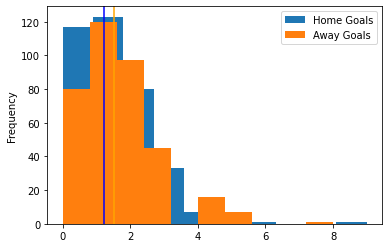

In [175]:
fixture_df['Home Goals'].plot.hist()
fixture_df['Away Goals'].plot.hist()
plt.axvline(fixture_df['Home Goals'].mean(), color='blue')
plt.axvline(fixture_df['Away Goals'].mean(), color='orange')

plt.legend()

In [145]:
len(fixture_df)

366

0      5
1      5
2      3
3      0
4      2
      ..
361    2
362    4
363    2
364    4
365    4
Name: Sum Goals, Length: 366, dtype: int64
2.7349726775956285


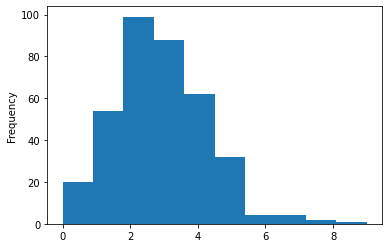

In [127]:
#Adding in sum of goals column
fixture_df['Sum Goals'] = fixture_df['Away Goals'] + fixture_df['Home Goals']
fixture_df['Sum Goals'].plot.hist()
print(fixture_df['Sum Goals'])
print(fixture_df['Sum Goals'].mean())

In [128]:
#Attempting bootstrapping goals to try to get normal distribution
fixture_df['Sum Goals'].value_counts(normalize=True)

2    0.270492
3    0.240437
4    0.169399
1    0.147541
5    0.087432
0    0.054645
7    0.010929
6    0.010929
8    0.005464
9    0.002732
Name: Sum Goals, dtype: float64

In [129]:
#Sample with replacement
bootstrapped_fixtures_df = pd.DataFrame({'Mean Goals' : [fixture_df['Sum Goals'].sample(25, replace=True).mean() for i in range(1000)]})

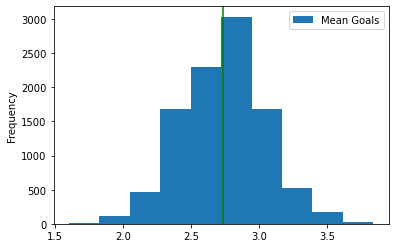

In [130]:
bootstrapped_fixtures_df.plot.hist()
plt.axvline(fixture_df['Sum Goals'].mean(), color='green')

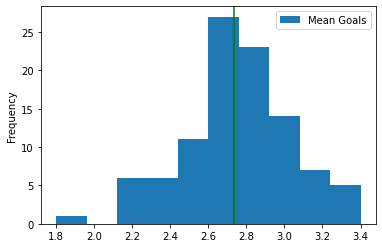

In [131]:
bootstrapped_fixtures_df_1 = pd.DataFrame({'Mean Goals' : [fixture_df['Sum Goals'].sample(25, replace=True).mean() for i in range(100)]})
bootstrapped_fixtures_df_1.plot.hist()
plt.axvline(fixture_df['Sum Goals'].mean(), color='green')

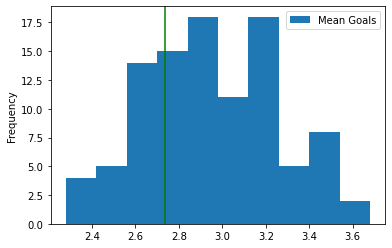

In [132]:
bootstrapped_fixtures_df_2 = pd.DataFrame({'Mean Goals' : [fixture_df['Sum Goals'].sample(25, replace=True).mean()+0.2 for i in range(100)]})
bootstrapped_fixtures_df_2.plot.hist()
plt.axvline(fixture_df['Sum Goals'].mean(), color='green')

In [134]:
#Validating calculations using scipy stats t-test
scipy.stats.ttest_ind(bootstrapped_fixtures_df_1['Mean Goals'], bootstrapped_fixtures_df_2['Mean Goals'])

NameError: name 'scipy' is not defined

In [135]:
#Testing using shaking hands example
coffee_array = np.array([34, 52, 26, 47, 42, 37, 40])
soda_array = np.array([39, 57, 68, 74, 49, 57])
calculate_t_statistic(coffee_array, soda_array)

Means: 39.714285714285715, 57.333333333333336
Stds: 7.90504876128967, 11.527744310527055
Counts: 7, 6
Std errors: 2.9878275891730945, 4.706181907677194
t_stat is -3.160639991435542
Number of deg_f are 11
Critical value is 1.7958848187036691
p value is 0.00907
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis
